## Example. Estimating the speed of light

Simon Newcomb's measurements of the speed of light, from

> Stigler, S. M. (1977). Do robust estimators work with real data? (with discussion). *Annals of
Statistics* **5**, 1055–1098. 

The data are recorded as deviations from $24\ 800$
nanoseconds.  Table 3.1 of Bayesian Data Analysis.

28 26 33 24 34 -44 27 16 40 -2
29 22 24 21 25 30 23 29 31 19
24 20 36 32 36 28 25 21 28 29
37 25 28 26 30 32 36 26 30 22
36 23 27 27 28 27 31 27 26 33
26 32 32 24 39 28 24 25 32 25
29 27 28 29 16 23

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns

from scipy.optimize import brentq

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

In [2]:
numbs = "28 26 33 24 34 -44 27 16 40 -2 29 22 \
24 21 25 30 23 29 31 19 24 20 36 32 36 28 25 21 28 29 \
37 25 28 26 30 32 36 26 30 22 36 23 27 27 28 27 31 27 26 \
33 26 32 32 24 39 28 24 25 32 25 29 27 28 29 16 23"

In [3]:
nums = np.array([int(i) for i in numbs.split(' ')])

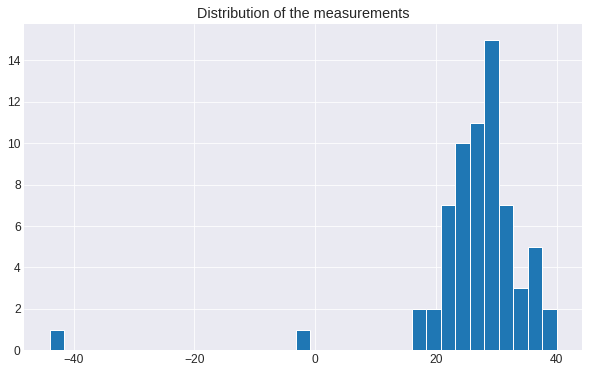

In [4]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(nums, bins=35, edgecolor='w')
plt.title('Distribution of the measurements');

In [5]:
mean_t = np.mean(nums)
print('The mean of the 66 measurements is {:.1f}'.format(mean_t))

The mean of the 66 measurements is 26.2


In [6]:
std_t = np.std(nums, ddof=1)
print('The standard deviation of the 66 measurements is {:.1f}'.format(std_t))

The standard deviation of the 66 measurements is 10.7


And now, we use `pymc3` to estimate the mean and the standard deviation from the data.

In [7]:
with pm.Model() as model_1:
    mu = pm.Uniform('mu', lower=10, upper=30)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    post = pm.Normal('post', mu=mu, sd=sigma, observed=nums)

In [9]:
with model_1:
    trace_1 = pm.sample(draws=50_000, tune=50_000, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 400000/400000 [02:42<00:00, 2462.96draws/s]


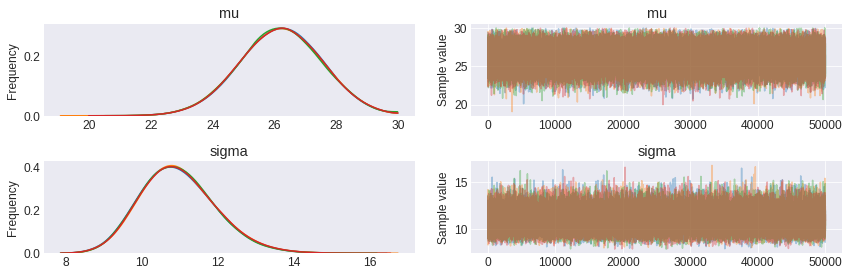

In [10]:
pm.traceplot(trace_1);

In [11]:
df = pm.summary(trace_1)
df.style.format('{:.4f}')

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,26.2036,1.3322,0.0041,23.6293,28.8666,101088.6714,1.0000
sigma,10.9538,0.9784,0.0031,9.1471,12.9323,84413.9423,1.0001


As you can see, the highest posterior interval for `mu` is [23.57, 28.82].

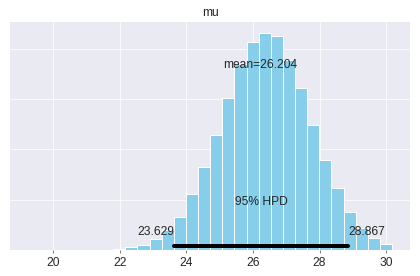

In [12]:
pm.plot_posterior(trace_1, varnames=['mu']);

The true posterior distribution is $t_{65}$

In [13]:
from scipy.stats import t

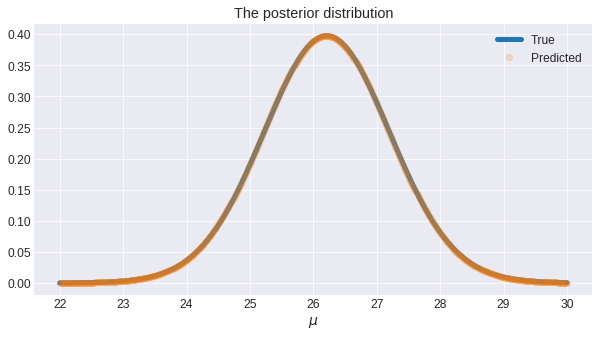

In [14]:
x = np.linspace(22, 30, 500)
y = t.pdf(x, 65, loc=mean_t)

y_pred = t.pdf(x, 65, loc=df['mean'].values[0])

plt.figure(figsize=(10, 5))
plt.plot(x, y, label='True', linewidth=5)
plt.plot(x, y_pred, 'o', label='Predicted', alpha=0.2)
plt.legend()
plt.title('The posterior distribution')
plt.xlabel(r'$\mu$', fontsize=14);

The book says you can find the posterior interval by simulation, so let's do that with Python. First, draw random values of $\sigma^2$ and $\mu$.

In [15]:
mu_estim = []

for i in range(10_000):
    y = np.random.chisquare(65)
    y2 = 65 * std_t**2 / y
    yy = np.random.normal(loc=mean_t, scale=y2/66)
    mu_estim.append(yy)

To visualize `mu_estim`, we plot a histogram.

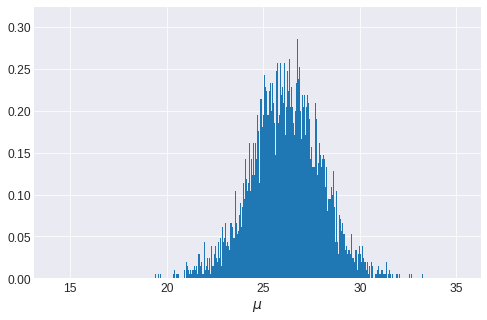

In [16]:
plt.figure(figsize=(8,5))
rang, bins1, _ = plt.hist(mu_estim, bins=1000, density=True)
plt.xlabel(r'$\mu$', fontsize=14);

The advantage here is that you can find the median and the central posterior interval. Well, the median is...

In [17]:
idx = bins1.shape[0] // 2
print((bins1[idx] + bins1[idx + 1]) / 2) 

24.71486070329976


And the central posterior interval is... not that easy to find. We have to find $a$ such as:

$$\int_{\mu -a}^{\mu +a} f(x)\, dx = 0.95,$$

with $\mu$ the median. We need to define $dx$ and $f(x)$. 


In [18]:
delta_bin = bins1[1] - bins1[0]
print('This is delta x: {}'.format(delta_bin))

This is delta x: 0.021013890143638747


We define a function to find $a$ (in fact, $a$ is an index). `rang` is $f(x)$.

In [19]:
def func3(a):
    return sum(rang[idx - int(a):idx + int(a)] * delta_bin) - 0.95

In [20]:
idx_sol = brentq(func3, 0, idx)
idx_sol

214.99999999999937

That number is an index, therefore the interval is:

In [21]:
l_i = bins1[idx - int(idx_sol)]
l_d = bins1[idx + int(idx_sol)]

print('The central posterior interval is [{:.2f}, {:.2f}]'.format(l_i, l_d))

The central posterior interval is [20.21, 29.20]


## Example. Pre-election polling

Let's put that in code.

In [22]:
obs = np.array([727, 583, 137])
bush_supp = obs[0] / sum(obs)
dukakis_supp = obs[1] / sum(obs)
other_supp = obs[2] / sum(obs)

arr = np.array([bush_supp, dukakis_supp, other_supp])
print('The proportion array is', arr)
print('The supporters array is', obs)

The proportion array is [0.5024188  0.40290256 0.09467865]
The supporters array is [727 583 137]


Remember that we want to find the distribution of $\theta_1 - \theta_2$. In this case, the prior distribution on each $\theta$ is a uniform distribution; the data $(y_1, y_2, y_3)$ follow a multinomial distribution, with parameters $(\theta_1, \theta_2, \theta_3)$.

In [80]:
import theano
import theano.tensor as tt

In [255]:
with pm.Model() as model_3:

    theta1 = pm.Uniform('theta1', lower=0, upper=1)
    theta2 = pm.Uniform('theta2', lower=0, upper=1)
#     theta3 = pm.Uniform('theta3', lower=0, upper=1)
#     theta3 = pm.Deterministic('theta3', 1 - theta1 - theta2)
    theta3 = 1 - theta1 - theta2
    post = pm.Multinomial('post', n=obs.sum(), p=[theta1, theta2, theta3], observed=obs)
    
    diff = pm.Deterministic('diff', theta1 - theta2)

In [256]:
model_3.check_test_point()

theta1_interval__   -1.390000
theta2_interval__   -1.390000
post                     -inf
Name: Log-probability of test_point, dtype: float64

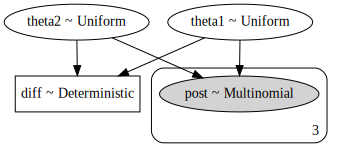

In [253]:
pm.model_to_graphviz(model_3)

In [254]:
with model_3:
    trace_3 = pm.sample(draws=10_000, tune=50_000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta2, theta1]
Sampling 2 chains:   0%|          | 0/120000 [00:00<?, ?draws/s]


RuntimeError: Chain 0 failed.

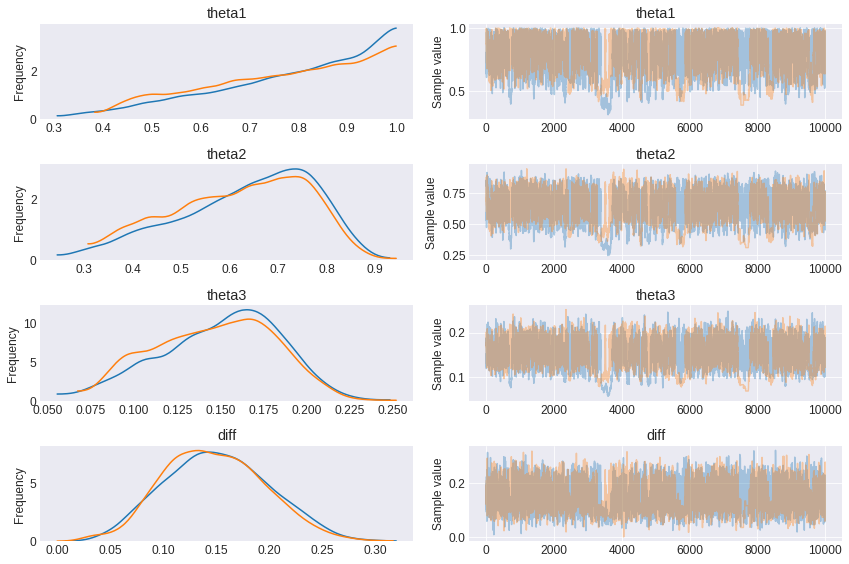

In [245]:
pm.traceplot(trace_3);

In [246]:
pm.summary(trace_3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,0.774854,0.165051,0.008724,0.466039,0.999897,207.464883,1.003432
theta2,0.625347,0.137917,0.007124,0.348555,0.844125,219.149134,1.003720
theta3,0.147695,0.034550,0.001741,0.081498,0.208520,228.557248,1.003427
diff,0.149507,0.048063,0.001645,0.063996,0.247554,527.434634,1.000650


In [75]:
pm.diagnostics.effective_n(trace_3)

{'theta1': 157.11045117557103,
 'theta2': 161.13630354585788,
 'theta3': 181.17813953156798,
 'diff': 424.0886277379521}

As you can see, the way we write the model is not good, that's why you see a lot of divergences and `n_eff` (the effective sample size) is very, very low. This can be improved.

In [31]:
with pm.Model() as model_4:
    theta = pm.Dirichlet('theta', a=np.ones_like(obs))
    post = pm.Multinomial('post', n=obs.sum(), p=theta, observed=obs)

In [32]:
with model_4:
    trace_4 = pm.sample(10_000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:22<00:00, 2662.09draws/s]


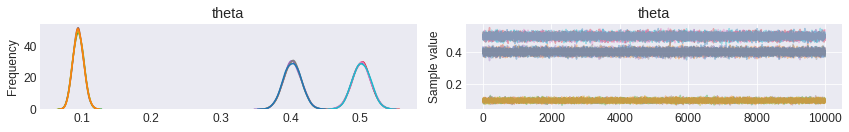

In [33]:
pm.traceplot(trace_4);

In [34]:
pm.summary(trace_4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta__0,0.502039,0.013131,0.000063,0.475984,0.527385,35243.084534,0.999997
theta__1,0.402773,0.012842,0.000063,0.377036,0.427133,35183.794742,0.999999
theta__2,0.095188,0.007750,0.000034,0.079811,0.110041,36723.973858,0.999976


Better trace plot and better `n_eff`. Now we can estimate $\theta_1 - \theta_2$, we draw 4000 points from the posterior distribution.

In [35]:
post_samples = pm.sample_ppc(trace_4, samples=4_000, model=model_4)

100%|██████████| 4000/4000 [00:03<00:00, 1140.46it/s]


In [36]:
diff = []
sum_post_sample = post_samples['post'].sum(axis=1)[0]

for i in range(post_samples['post'].shape[0]):
    diff.append((post_samples['post'][i, 0] - 
                post_samples['post'][i, 1]) /  sum_post_sample)

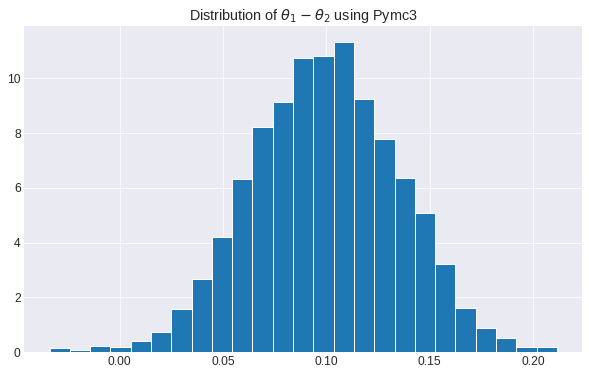

In [37]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(diff, bins=25, edgecolor='w', density=True)
plt.title(r'Distribution of $\theta_1 - \theta_2$ using Pymc3');

Of course you can compare this result with the true posterior distribution

In [38]:
from scipy.stats import dirichlet

In [39]:
ddd = dirichlet([728, 584, 138])

rad = []
for i in range(4_000):
    rad.append(ddd.rvs()[0][0] - ddd.rvs()[0][1])

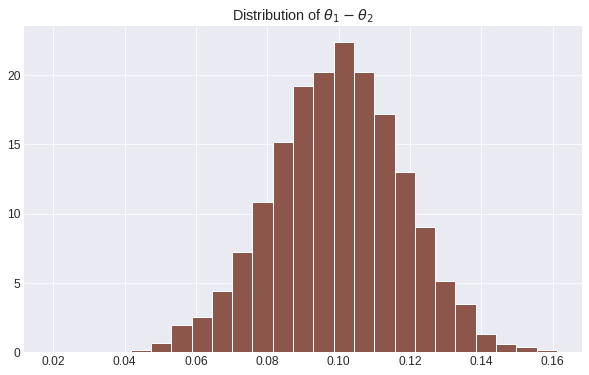

In [40]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(rad, color='C5', bins=25, edgecolor='w', density=True)
plt.title(r'Distribution of $\theta_1 - \theta_2$');

/home/rosgori/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


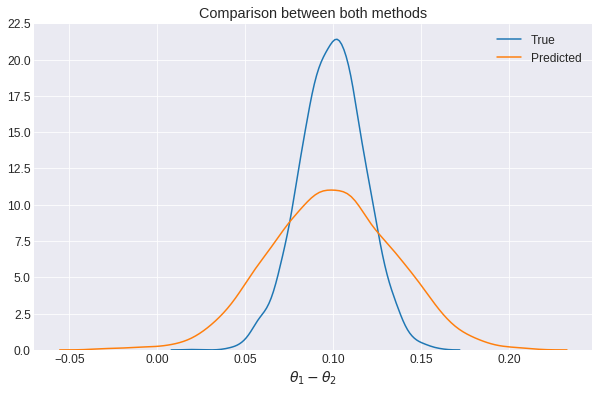

In [41]:
plt.figure(figsize=(10, 6))
sns.kdeplot(rad, label='True')
sns.kdeplot(diff, label='Predicted');
plt.title('Comparison between both methods')
plt.xlabel(r'$\theta_1 - \theta_2$', fontsize=14);

## Example: analysis of a bioassay experiment

In [42]:
x_dose = np.array([-0.86, -0.3, -0.05, 0.73])
n_anim = np.array([5, 5, 5, 5])
y_deat = np.array([0, 1, 3, 5])

In [43]:
with pm.Model() as model_5:
    alpha = pm.Uniform('alpha', lower=-5, upper=7)
    beta = pm.Uniform('beta', lower=0, upper=50)
    
    theta = pm.math.invlogit(alpha + beta * x_dose)
    
    post = pm.Binomial('post', n=n_anim, p=theta, observed=y_deat)

In [44]:
with model_5:
    trace_5 = pm.sample(draws=10_000, tune=15_000, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 100000/100000 [00:46<00:00, 2151.53draws/s]


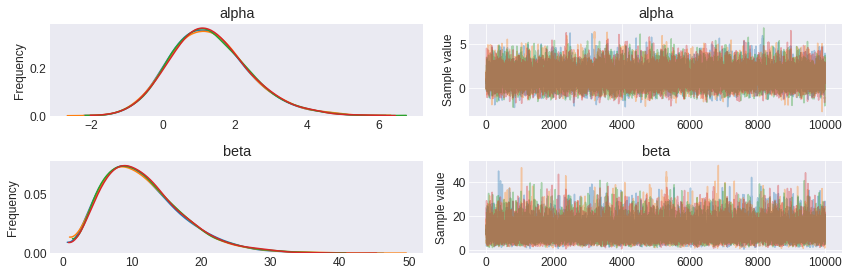

In [45]:
pm.traceplot(trace_5);

In [46]:
pm.summary(trace_5)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.321840,1.108414,0.008470,-0.787939,3.540989,14104.810855,0.999997
beta,11.701018,5.843734,0.043741,2.591447,23.258832,13301.081509,1.000077


In [47]:
trace_5.varnames

['alpha_interval__', 'beta_interval__', 'alpha', 'beta']

In [257]:
post_samples2 = pm.sample_ppc(trace_5, samples=2000, model=model_5)

100%|██████████| 2000/2000 [00:01<00:00, 1721.89it/s]


In [259]:
for i in range(4):
    print(post_samples2['post'][:, i][-200:])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0]
[0 2 0 0 0 0 3 1 1 1 0 4 2 1 0 0 1 0 1 2 0 1 0 0 0 0 1 2 0 3 0 4 1 2 1 0 0
 0 0 1 0 1 0 0 0 1 2 0 3 1 1 0 0 3 0 1 2 1 0 1 0 0 0 2 0 0 1 1 1 0 0 1 3 0
 0 1 0 0 0 0 1 0 0 0 1 0 2 0 0 2 0 2 1 1 1 0 1 1 2 1 0 0 1 2 0 0 0 0 4 2 0
 2 2 1 0 0 0 3 0 0 0 3 2 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 3 0 1 1 2 0 0 0
 4 0 0 2 1 1 0 0 0 0 0 1 0 1 0 1 0 2 1 1 1 0 2 0 0 2 0 0 0 3 0 1 0 1 0 2 2
 1 0 0 1 3 1 1 2 0 1 0 0 3 1 1]
[1 5 3 4 3 5 3 3 3 4 4 5 3 5 4 4 2 2 4 3 0 4 2 5 1 2 4 5 2 5 3 3 3 2 2 4 2
 3 4 2 3 4 5 1 5 3 5 3 4 3 3 3 2 4 1 4 4 4 2 5 2 4 5 2 4 3 3 4 3 5 3 3 5 5
 4 3 2 1 5 4 4 1 5 4 5 4 4 1 4 2 5 1

In [50]:
pm.invlogit(1.32+11.68*-0.3).eval()

array(0.10119652)

In [ ]:
post_samples2['post']

In [ ]:
%load_ext watermark

In [ ]:
%watermark -iv -v -p theano,scipy,matplotlib -m